<a href="https://colab.research.google.com/github/miguelsmachado/data_science/blob/master/Detec%C3%A7%C3%A3o_de_Fraude_em_Cart%C3%B5es_de_Cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
![alt text](https://github.com/miguelsmachado/py_projects/blob/master/banner.png?raw=true)

#### **Data Science na Prática 2.0**
*by [Miguel S. Machado](https://www.linkedin.com/in/miguel-s-machado/)*

---

# Detecção de Fraudes em Cartões de Crédito

Neste estudo, iremos abordar o problema das fraudes em cartões de crédito, uma das principais preocupações das instituições financeiras como bancos e *fintechs*. Apenas no Brasil, cerca de 12,1 milhões de pessoas já foram vítimas de algum tipo de fraude financeira no último ano. Traduzindo em valores, os golpes financeiros ultrapassaram a cifra de R$ 1,8 bilhão de prejuízo por ano para os últimos 12 meses.


Dentra essas fraudes, aquelas envolvendo cartões de crédito são de grande relevância uma vez que a sua não-detecção acaretará em prejuízos consideráveis, tanto para o consumidor quanto para a instituição financeira.

Um outro fator a ser considerado é a quantidade de falsos positivos, ou seja, aquelas vezes em que você tentou fazer uma compra e teve seu cartão bloqueado preventivamente - o que provavelmente gerou estresse e constrangimento.

Por todos esses motivos, o investimento na área de detecção de fraudes por meio de Inteligência Artificial vem crescendo a cada ano, representando uma grande oportunidade em *Data Science*. 

Dispondo de grandes volumes de dados como base histórica, um algoritmo de machine learning apenas um pouco melhor que os anteriores já representa uma economia de milhões de Reais. E esse é o desafio, aprimorar cada vez mais o uso de algoritmos visando inibir ou evitar transações fraudulentas.

## Importando os Dados

Os dados que usaremos neste projeto foram disponibilizados por algumas empresas européias de cartão de crédito. O *dataset* representa as operações financeiras que aconteceram no período de dois dias, onde foram classificadas 492 fraudes em meio a quase 290 mil transações.

Como você pode notar, este é um conjunto de dados extremamente desbalanceado, onde as fraudes representam apenas 0,17% do total.

Outro detalhe interessante é que as *features* são todas numéricas, e foram descaracterizadas (por problemas ligados à privacidade e segurança). Assim, os nomes das colunas são representados por $[V1, V2, V3 \dots, V28]$ 

<p align=center>
<img src="http://sigmoidal.ai/wp-content/uploads/2019/12/54.jpg" width="50%"></p>

[Na página original dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), também é informado que as variáveis passaram por uma transformação conhecida como Análise de Componentes Principais (*Principal Component Analysis* - PCA).

A PCA permite a redução da dimensionalidade enquanto mantém o maior número possível de informações. Para conseguir isso, o algoritmo encontra um conjunto novo de recursos - os chamados **componentes**.

Esses componentes são em número menor or igual às variáveis originais. No caso deste projeto, os componentes achados pela transformação da PCA são as próprias colunas $[V1, V2, V3 \dots, V28]$.

In [75]:
!pip install -q scikit-plot

In [112]:
# importando os pacotes necessários
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
import scikitplot as skplt

import warnings
warnings.filterwarnings('ignore')

sns.set()

In [55]:
file_path = "https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"

# importar os dados para um dataframe
df = pd.read_csv(file_path)

## Análise Exploratória

Vamos iniciar nossa análise dando uma olhada geral em nosso DataFrame

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Agora, vamos dar uma olhada em um resumo estatístico dos dados:

In [5]:
df.describe().round(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,1.09,1.02,1.00,1.00,0.96,0.92,0.88,0.85,0.84,0.81,0.77,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,-24.59,-4.80,-18.68,-5.79,-19.21,-4.50,-14.13,-25.16,-9.50,-7.21,-54.50,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,-0.54,-0.76,-0.41,-0.65,-0.43,-0.58,-0.47,-0.48,-0.50,-0.46,-0.21,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,-0.09,-0.03,0.14,-0.01,0.05,0.05,0.07,-0.07,-0.00,0.00,-0.06,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,0.45,0.74,0.62,0.66,0.49,0.65,0.52,0.40,0.50,0.46,0.13,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,23.75,12.02,7.85,7.13,10.53,8.88,17.32,9.25,5.04,5.59,39.42,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


Como o DataFrame passou pelo processo de PCA, podemos ver que as médias de todos os dados é 0.

Vamos verificar agora, se existem valores ausentes em nosso DataSet

In [9]:
df.isnull().sum().sum()

0

Como pode ser verificado, não há dados faltantes.

### Verificando o balanceamento do dataset

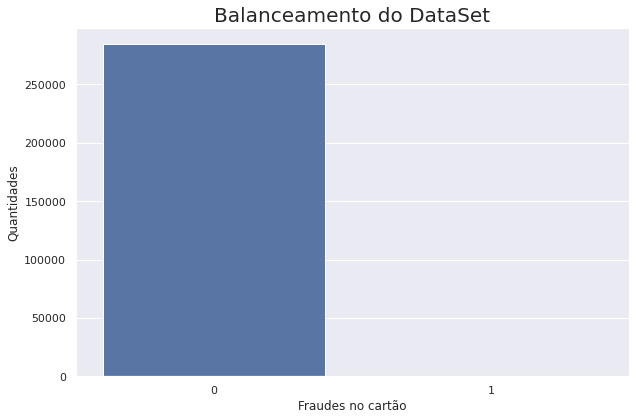

In [20]:
fig, ax = plt.subplots(figsize=(9,6))

ax = sns.countplot(df.Class)
ax.set_title("Balanceamento do DataSet", fontsize=20)
ax.set_xlabel("Fraudes no cartão")
ax.set_ylabel("Quantidades")

plt.tight_layout()

Aqui encontramos um primeiro problema. Nosso dataset está extremamente desbalanceado. A quantidade de valores que não são fraudes, é muito maior que os valores que são fraude. Isso pode gerar um problema muito grande na hora de treinarmos o modelo, pois ele será muito mais treinado com entradas que não são fraudes.

Para que nosso modelo de machine learning seja eficiente, trataremos esse problema mais para frente.

### Verificando a distribuição da variável `Time` 

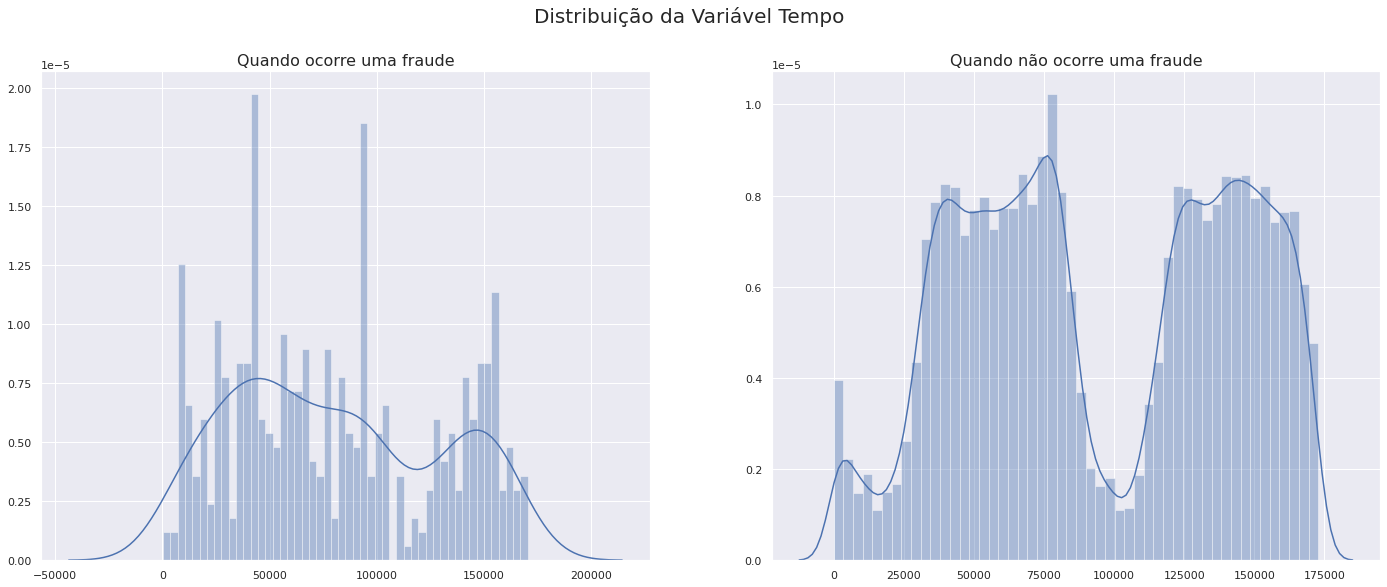

In [36]:
fig, ax = plt.subplots(figsize=(24,9))
fig.suptitle("Distribuição da Variável Tempo", fontsize=20)

plt.subplot(1,2,1)
ax = sns.distplot(df.query('Class == 1')['Time'], bins=50)
ax.set_title("Quando ocorre uma fraude", fontsize=16)
ax.set_ylabel("")
ax.set_xlabel("")

plt.subplot(1,2,2)
ax = sns.distplot(df.query('Class == 0')['Time'], bins=50)
ax.set_title("Quando não ocorre uma fraude",  fontsize=16)
ax.set_ylabel("")
ax.set_xlabel("")

plt.show()

No plot acima podemos ver como se comporta a ditribuição da variável `Time`, em duas situação distintas. À esquerda, nas vezes em que ocorreram fraudes e à direita, quando não ocorreu fraude.

### Verificando a distribuição da variável `Amount` 

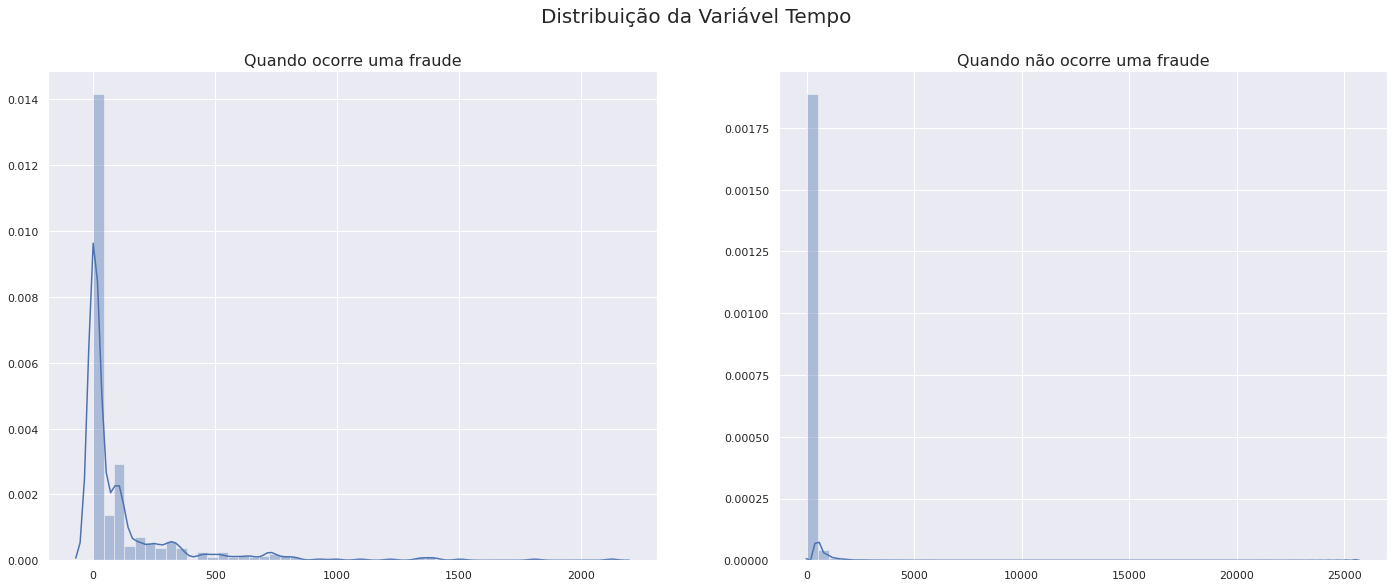

In [38]:
fig, ax = plt.subplots(figsize=(24,9))
fig.suptitle("Distribuição da Variável Tempo", fontsize=20)

plt.subplot(1,2,1)
ax = sns.distplot(df.query('Class == 1')['Amount'])
ax.set_title("Quando ocorre uma fraude", fontsize=16)
ax.set_ylabel("")
ax.set_xlabel("")

plt.subplot(1,2,2)
ax = sns.distplot(df.query('Class == 0')['Amount'])
ax.set_title("Quando não ocorre uma fraude",  fontsize=16)
ax.set_ylabel("")
ax.set_xlabel("")

plt.show()


Da mesma forma que na situação acima, vamos analisar como se comporta a ditribuição da variável `Amount`, em duas situação distintas. À esquerda, nas vezes em que ocorreram fraudes e à direita, quando não ocorreu fraude.

Abaixo, usando um boxplot, podemos ter uma visão diferente da mesma que vimos acima. Como se comporta a distribuição dos valores da variável `Amount` em situações em que ocorreram golpes no cartão de crédito.

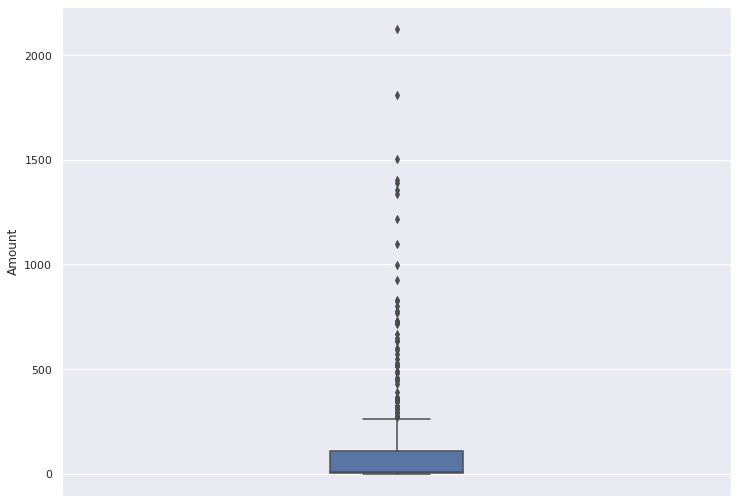

In [44]:
fig, ax = plt.subplots(figsize=(12,9))

ax = sns.boxplot(df.query('Class == 1')['Amount'], orient='v', width=0.2)

### Matriz de Correlação

In [46]:
df.corr().round(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000,0.117,-0.011,-0.420,-0.105,0.173,-0.063,0.085,-0.037,-0.009,0.031,-0.248,0.124,-0.066,-0.099,-0.183,0.012,-0.073,0.090,0.029,-0.051,0.045,0.144,0.051,-0.016,-0.233,-0.041,-0.005,-0.009,-0.011,-0.012
V1,0.117,1.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.228,-0.101
V2,-0.011,0.000,1.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.531,0.091
V3,-0.420,-0.000,0.000,1.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.211,-0.193
V4,-0.105,0.000,-0.000,-0.000,1.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.099,0.133
V5,0.173,0.000,-0.000,-0.000,-0.000,1.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,-0.386,-0.095
V6,-0.063,0.000,0.000,0.000,-0.000,0.000,1.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.216,-0.044
V7,0.085,0.000,0.000,0.000,0.000,-0.000,0.000,1.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.397,-0.187
V8,-0.037,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,1.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.103,0.020
V9,-0.009,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,1.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.044,-0.098


Pelo fato dos valores terem passados pelo processo do PCA, podemos ver que a relação entre eles é 0.

Os únicos valores que possuem correlações para serem analisadas são, `Time`, `Class` e `Amount`

## Preparação dos Dados

### Normalizando os dados

Para que nosso DataSet esteja pronto para ser treinando, precisamos normalizar alguns dados (`Time`e `Amount`).

Como esses valores não passaram pelo PCA, precisam ser normalizados antes que o modelo seja treinado.

Para isso, usaremos a seguinte fórmula:

![texto alternativo](https://miro.medium.com/max/922/1*gcKMS2l3wgrh3TAvrssUmw.png)

Vamos criar uma função e aplicar para todos os valores das colunas:

In [57]:
def normalizacao(coluna):
  minimo = df[f'{coluna}'].min()
  maximo = df[f'{coluna}'].max()
  df[f'{coluna}'] = (df[f'{coluna}'] - minimo) / (maximo - minimo)

In [58]:
normalizacao('Amount')
normalizacao('Time')

In [62]:
df[['Time', 'Amount']].head()

,Time,Amount
0,0.000000,0.005824
1,0.000000,0.000105
2,0.000006,0.014739
3,0.000006,0.004807
4,0.000012,0.002724


Acima podemos ver as colunas já normalizadas

### Separando dados entre treino e teste

O nosso modelo terá como variável dependende a coluna `Class` e todos restante do DataFrame como variáveis explicativas

In [66]:
X = df.drop('Class', axis=1)
y = df['Class']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Balanceando os dados

Conforme dito anteriormente, vamos balancear os dados para que nosso modelo não tenha um viés na hora de ser treinado:

In [119]:
rus = RandomUnderSampler()
X_res, y_res = rus.fit_sample(X_train, y_train)

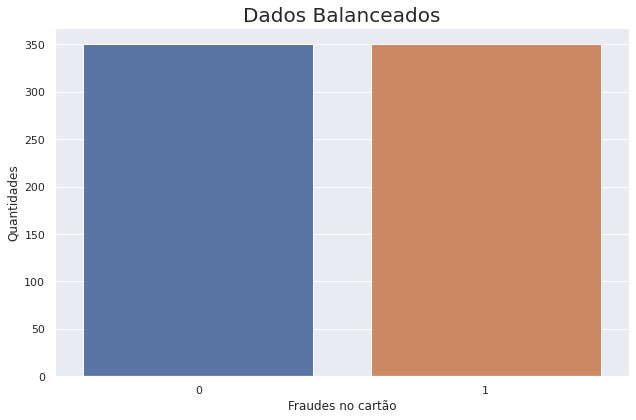

In [120]:
fig, ax = plt.subplots(figsize=(9,6))

ax = sns.countplot(y_res)
ax.set_title("Dados Balanceados", fontsize=20)
ax.set_xlabel("Fraudes no cartão")
ax.set_ylabel("Quantidades")

plt.tight_layout()


## Modelo de Machine Learning

Agora que temos nossos dados balanceados, vamos treinar nossos modelos!

Para nosso estudo, utilizaremos 2 modelos diferente.
* Regressão Linear
* Árvore de Decisões

Primeiro, vamos instanciar um modelo de **Regressão Logística** e treinar com os dados balanceados

In [ ]:
model_res = LogisticRegression()
model_res.fit(X_res, y_res)

Fazer as previsões em cima dos dados de teste

In [ ]:
y_pred_res = model_res.predict(X_test)
y_proba_res = model_res.predict_proba(X_test)

Agora, vamos instanciar um modelo de **Decision Tree** para podermos comparar os resultados obtidos

In [ ]:
model_res_t = DecisionTreeClassifier()
model_res_t.fit(X_res, y_res)

Fazendo predições, mas agora com o modelo de Decision Tree

In [108]:
y_pred_res_t = model_res_t.predict(X_test)
y_proba_res_t = model_res_t.predict_proba(X_test)

## Avaliar o desempenho do modelo

Agora que temos nossos 2 modelos treinados, vamos comparar os resultados obtidos:

In [109]:
print("Relatório de Classificação:\n\nRegressão Logística\n\n", classification_report(y_test, y_pred_res, digits=4))
print()
print("Relatório de Classificação:\n\nDecision Tree\n\n", classification_report(y_test, y_pred_res_t, digits=4))

Relatório de Classificação:

Regressão Logística

               precision    recall  f1-score   support

           0     0.9999    0.9647    0.9820     71060
           1     0.0504    0.9366    0.0956       142

    accuracy                         0.9647     71202
   macro avg     0.5251    0.9507    0.5388     71202
weighted avg     0.9980    0.9647    0.9802     71202


Relatório de Classificação:

Decision Tree

               precision    recall  f1-score   support

           0     0.9998    0.9029    0.9489     71060
           1     0.0184    0.9085    0.0360       142

    accuracy                         0.9029     71202
   macro avg     0.5091    0.9057    0.4924     71202
weighted avg     0.9978    0.9029    0.9471     71202



Como podemos analisar acima, ambos os modelos apresentaram bons resultados (acima de 90% de acurácia) e também apresentaram bons resultados tanto para identificar quando é fraude e quando não é fraude

Para facilitar a visualização, vamos plotar as 2 matrizes de confusão:

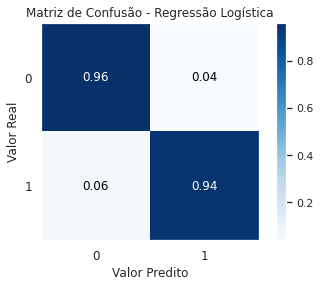

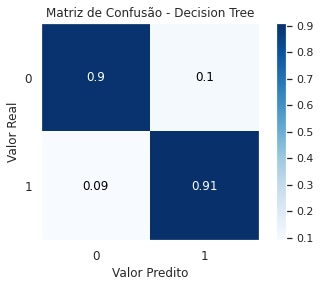

In [122]:
ax = skplt.metrics.plot_confusion_matrix(y_test, y_pred_res, normalize=True)
ax.set_title("Matriz de Confusão - Regressão Logística")
ax.set_xlabel("Valor Predito")
ax.set_ylabel("Valor Real")

ax = skplt.metrics.plot_confusion_matrix(y_test, y_pred_res_t, normalize=True)
ax.set_title("Matriz de Confusão - Decision Tree")
ax.set_xlabel("Valor Predito")
ax.set_ylabel("Valor Real")

plt.show()

Para interpretar a matriz é muito simples. Basta cruzar os números 0 e 1 dos eixos preditos e real.

Por exemplo: 
- No modelo de regressão Logística, quando o valor real era 0, o valor predito foi 0 em 96% dos casos, assim como quando o valor real era 1, o valor predito foi 1 em 94% dos casos.

- No modelo de árvore de decisão, quando o valor real era 0, o valor predito foi 0 em 90% dos casos, assim como quando o valor real era 1, o valor predito foi 1 em 91% dos casos.

Dessa forma, confirmamos que nossos modelos atingiram bons resultados!

## Modelo de Machine Learning Desbalanceado

Agora, vamos ver o que aconteceria se não tivessemos realizado o balanceamento dos dados.


Primeiro, vamos instanciar um modelo de Regressão Logística e treinar com os dados **desbalanceados**

In [124]:
model = LogisticRegression()
model.fit(X_train, y_train);

Fazer as previsões em cima dos dados de teste

In [114]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

Agora, vamos instanciar um modelo de Decision Tree (**com os dados desbalanceados**) para podermos comparar os resultados obtidos

In [115]:
model_t = DecisionTreeClassifier()
model_t.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Fazendo predições, mas agora com o modelo de Decision Tree com os dados **desbalanceados**

In [116]:
y_pred_t = model_t.predict(X_test)
y_proba_t = model_t.predict_proba(X_test)

## Avaliação o desempenho do modelo com dados **desbalanceados**


In [117]:
print("Relatório de Classificação:\n\nRegressão Logística\n\n", classification_report(y_test, y_pred, digits=4))
print()
print("Relatório de Classificação:\n\nDecision Tree\n\n", classification_report(y_test, y_pred_t, digits=4))

Relatório de Classificação:

Regressão Logística

               precision    recall  f1-score   support

           0     0.9992    0.9998    0.9995     71060
           1     0.8842    0.5915    0.7089       142

    accuracy                         0.9990     71202
   macro avg     0.9417    0.7957    0.8542     71202
weighted avg     0.9990    0.9990    0.9989     71202


Relatório de Classificação:

Decision Tree

               precision    recall  f1-score   support

           0     0.9994    0.9995    0.9994     71060
           1     0.7299    0.7042    0.7168       142

    accuracy                         0.9989     71202
   macro avg     0.8647    0.8519    0.8581     71202
weighted avg     0.9989    0.9989    0.9989     71202



Se olharmos somente para acurácia, vamos achar que atingimos um bom resultado, mas quando olhamos para a coluna `recall` e analisamos nosso acertos nas vezes em que era fraude, vemos que tivemos resultados muito inferiores.

Vamos visualizar isso de uma forma mais simples e compreender melhor nosso resultado na matriz de confusão

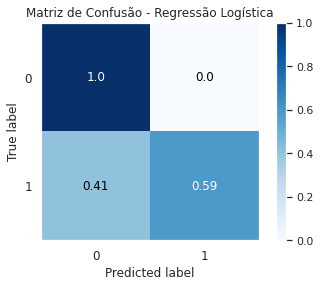

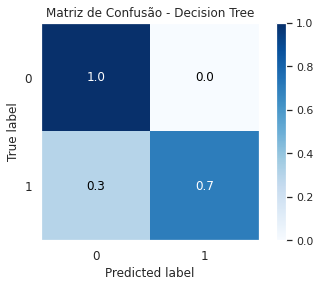

In [118]:
ax = skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
ax.set_title("Matriz de Confusão - Regressão Logística")

ax = skplt.metrics.plot_confusion_matrix(y_test, y_pred_t, normalize=True)
ax.set_title("Matriz de Confusão - Decision Tree")

plt.show()

Vamos realizar a mesma interpretação que fizemos para os modelos balanceados:
 
- No modelo de regressão Logística, quando o valor real era 0, o valor predito foi 0 em 100% dos casos, mas quando o valor real era 1, o valor predito foi 1 em apenas 59% dos casos.

- No modelo de árvore de decisão, quando o valor real era 0, o valor predito foi 0 em 100% dos casos, mas quando o valor real era 1, o valor predito foi 1 em 70% dos casos.


## Conclusão

Os Modelos de Machine Learning podem ser de grande valia na sociedade moderna, auxiliando o ser humano a automatizar diversos processo complexos, como nosso exemplo acima.

Mas todo esse "poder" deve ser tratado com responsabilidade pelos profissionais que modelam essas máquinas. Como vimos acima, se não tivermos paciência para realizar uma boa análise dos dados podemos gerar resultados falsos e criar grande problemas.

Se os dados não fossem balanceados, iriamos gerar um modelo relativamente bom (com uma boa acurácia), mas que só iria detectar trasações que não são fraude.

Por essa motivo, o trabalho sempre deve ser bem faseado e minuncioso, buscando sempre uma análise detalhada para evitar que nosso modelo tenha algum viés.